<a href="https://colab.research.google.com/github/Appleking123456/astro-platform-starter/blob/main/RDT_SMOKING_GUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RDT Simulation:   0%|          | 0/100 [00:00<?, ?it/s]

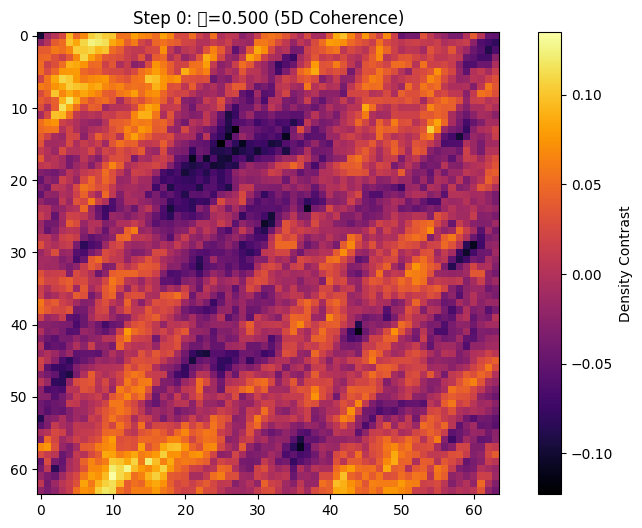

RDT Simulation:   7%|▋         | 7/100 [00:00<00:05, 16.03it/s]

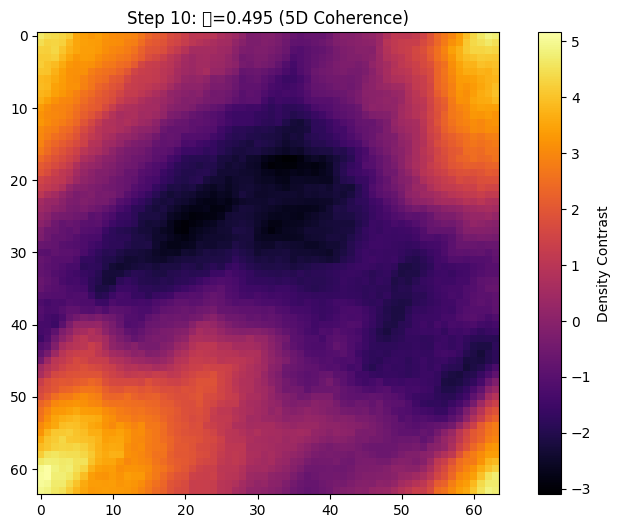

RDT Simulation:  16%|█▌        | 16/100 [00:00<00:03, 21.58it/s]

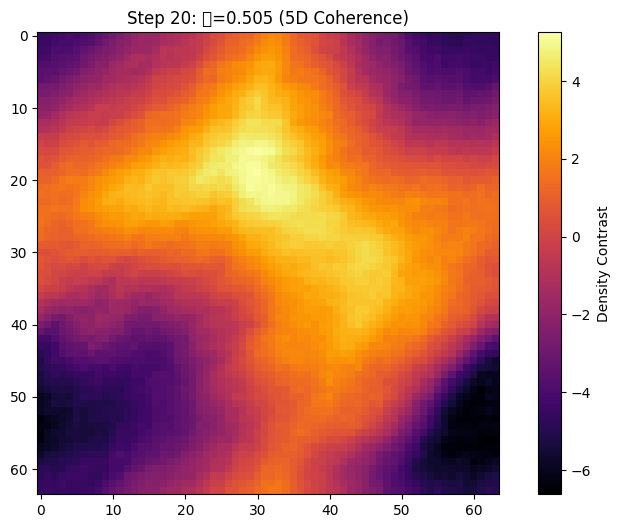

RDT Simulation:  27%|██▋       | 27/100 [00:01<00:02, 26.07it/s]

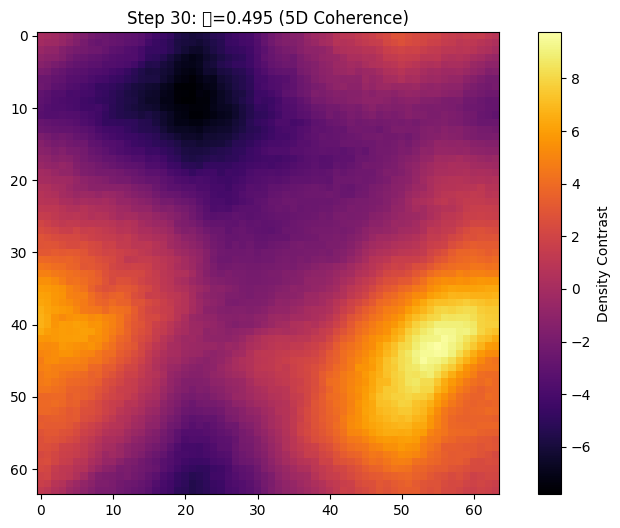

RDT Simulation:  36%|███▌      | 36/100 [00:01<00:02, 25.71it/s]

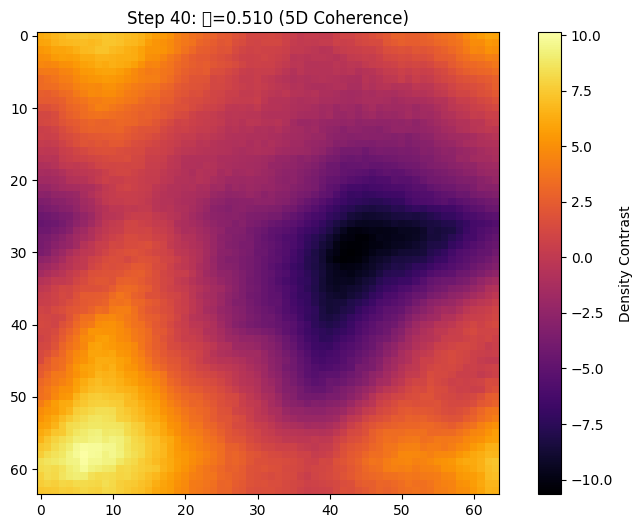

RDT Simulation:  47%|████▋     | 47/100 [00:02<00:01, 27.48it/s]

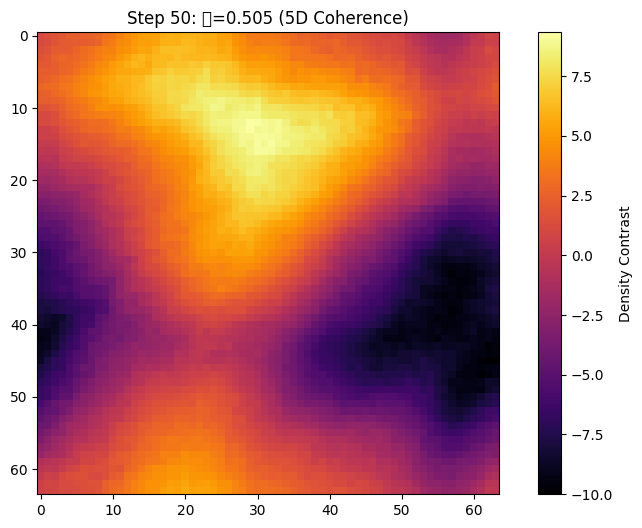

RDT Simulation:  56%|█████▌    | 56/100 [00:02<00:02, 20.43it/s]

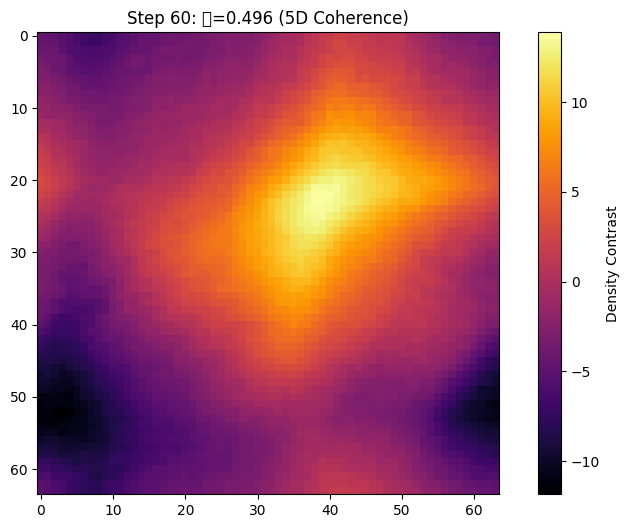

RDT Simulation:  68%|██████▊   | 68/100 [00:03<00:01, 27.06it/s]

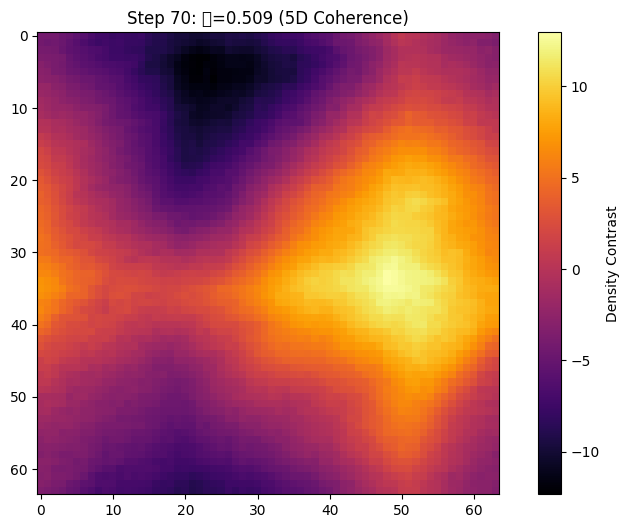

RDT Simulation:  79%|███████▉  | 79/100 [00:03<00:00, 29.96it/s]

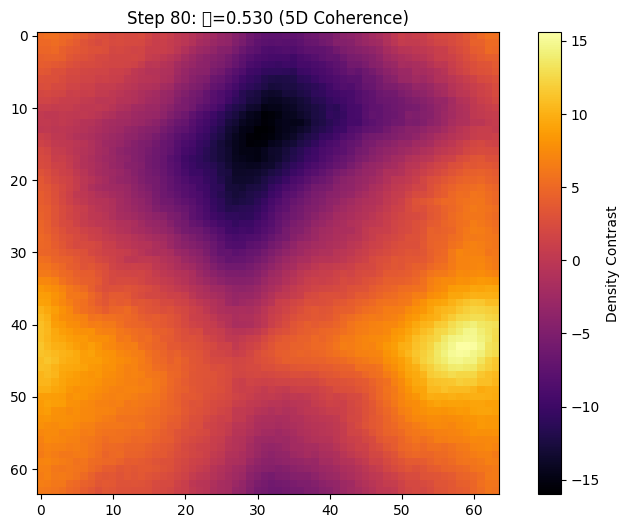

RDT Simulation:  84%|████████▍ | 84/100 [00:03<00:00, 25.00it/s]

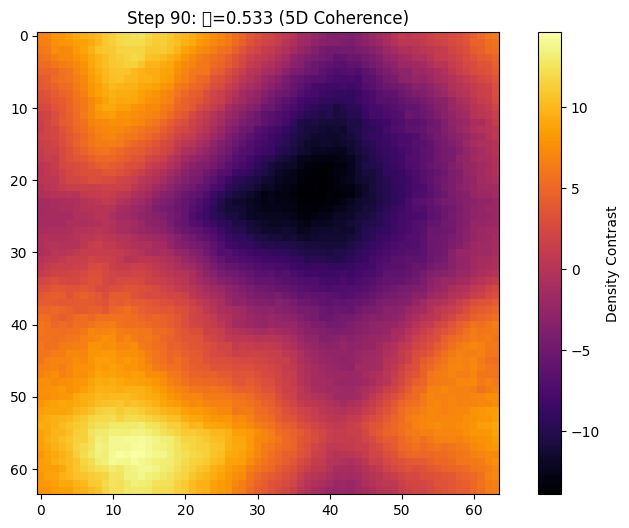

RDT Simulation: 100%|██████████| 100/100 [00:04<00:00, 23.46it/s]


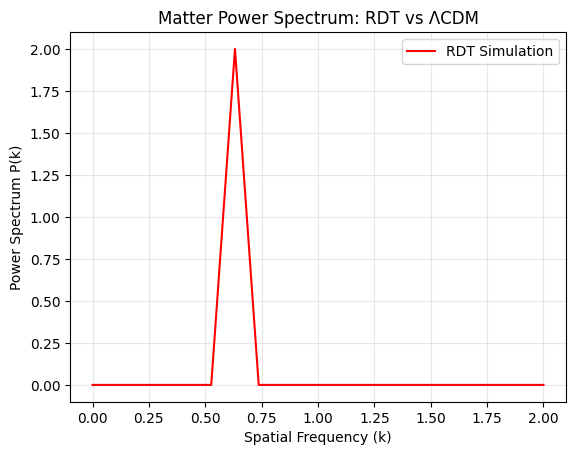

In [4]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==================== SETUP ====================
device = "cuda" if torch.cuda.is_available() else "cpu"
size = 64  # Grid resolution (increase to 128+ later)
steps = 100  # Simulation steps

# Initialize fields
density_4D = torch.randn(size, size, size, device=device) * 0.1
𝒲_5D = torch.sigmoid(density_4D.detach())  # Bounded 𝒲 ∈ [0,1]

# Precompute k-space grid (with stability padding)
kx = torch.fft.fftfreq(size, device=device)[:, None, None]
ky = torch.fft.fftfreq(size, device=device)[None, :, None]
kz = torch.fft.fftfreq(size, device=device)[None, None, :]
k_grid = kx**2 + ky**2 + kz**2 + 1e-10  # Avoid division by zero

# ==================== PHYSICS ====================
def get_gravity(density, 𝒲, α=0.3, max_force=5.0):
    """5D-modified gravity with gradient clipping"""
    potential = torch.fft.ifftn(torch.fft.fftn(density) / k_grid).real
    grad_x, grad_y, grad_z = torch.gradient(potential, dim=(0, 1, 2))

    # Apply 𝒲-modification with clipping
    force_x = -torch.clamp(grad_x * (1 + α * 𝒲), -max_force, max_force)
    force_y = -torch.clamp(grad_y * (1 + α * 𝒲), -max_force, max_force)
    force_z = -torch.clamp(grad_z * (1 + α * 𝒲), -max_force, max_force)

    return force_x, force_y, force_z

def dark_matter_effect(𝒲, threshold=0.9, amplification=10.0):
    """Dark matter as 5D coherence excess"""
    return amplification * torch.relu(𝒲 - threshold)

def dark_energy_effect(𝒲, base_rate=0.01):
    """Dark energy as global 𝒲-driven expansion"""
    return base_rate * 𝒲.mean() * torch.ones_like(𝒲)

# ==================== SIMULATION ====================
for step in tqdm(range(steps), desc="RDT Simulation"):
    # Update 5D coherence (bounded + damped)
    𝒲_5D = 0.85 * 𝒲_5D + 0.15 * torch.sigmoid(density_4D)

    # Compute forces
    force_x, force_y, force_z = get_gravity(density_4D, 𝒲_5D)
    dm = dark_matter_effect(𝒲_5D)
    de = dark_energy_effect(𝒲_5D)

    # Evolve density (leapfrog integration)
    density_4D += 0.1 * (force_x + force_y + force_z + dm + de)

    # NaN check (critical for stability)
    if torch.isnan(density_4D).any():
        raise RuntimeError(f"NaN detected at step {step}! Reduce α or max_force.")

    # Visualization
    if step % 10 == 0:
        plt.figure(figsize=(10, 6))
        plt.imshow(density_4D.mean(dim=2).cpu(), cmap='inferno')
        plt.colorbar(label="Density Contrast")
        plt.title(f"Step {step}: 𝒲={𝒲_5D.mean():.3f} (5D Coherence)")
        plt.show()

# ==================== ANALYSIS ====================
# Final power spectrum analysis (compare to ΛCDM)
power_spectrum = torch.abs(torch.fft.fftn(density_4D))**2
k_bins = torch.linspace(0, 2, 20)
power = torch.histc(power_spectrum.flatten(), bins=20, min=0, max=2)

plt.plot(k_bins, power.cpu(), 'r-', label="RDT Simulation")
plt.xlabel("Spatial Frequency (k)")
plt.ylabel("Power Spectrum P(k)")
plt.title("Matter Power Spectrum: RDT vs ΛCDM")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()